In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pearsonr, probplot

# Load
df = pd.read_csv("/Users/reynoldtakurachoruma/Downloads/amz_uk_price_prediction_dataset.csv")  
# Basic cleaning (example)
df = df.drop_duplicates()
df['isBestSeller'] = df['isBestSeller'].astype(bool)
df['category'] = df['category'].astype('category')

# Copy for outlier removal in price
price_q1 = df['price'].quantile(0.25)
price_q3 = df['price'].quantile(0.75)
iqr = price_q3 - price_q1
lower = price_q1 - 1.5 * iqr
upper = price_q3 + 1.5 * iqr

df_no_out = df[(df['price'] >= lower) & (df['price'] <= upper)]


In [4]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [5]:
df.describe()

,uid,stars,reviews,price,boughtInLastMonth
count,2.443651e+06,2.443651e+06,2.443651e+06,2.443651e+06,2.443651e+06
mean,1.370545e+06,2.152836e+00,4.806278e+02,8.924381e+01,2.589699e+01
std,8.160562e+05,2.194865e+00,5.944124e+03,3.456089e+02,2.404837e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.589215e+05,0.000000e+00,0.000000e+00,9.990000e+00,0.000000e+00
50%,1.349029e+06,0.000000e+00,0.000000e+00,1.909000e+01,0.000000e+00
75%,2.060686e+06,4.400000e+00,5.900000e+01,4.599000e+01,0.000000e+00
max,2.828593e+06,5.000000e+00,1.356658e+06,1.000000e+05,5.000000e+04


# Best seller vs category

# cross tab and proportions 

In [6]:
ct = pd.crosstab(df['category'], df['isBestSeller'])
ct_prop = ct.div(ct.sum(axis=1), axis=0)

# Sort by proportion of best sellers (True)
best_seller_share = ct_prop[True].sort_values(ascending=False)
best_seller_share.head(10)


category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Wind Instruments                  0.028000
Mirrors                           0.028000
Name: True, dtype: float64

When comparing the share of best sellers within each category, Grocery, Smart Home Security & Lighting, and Health & Personal Care stand out, with around 5.7 – 5.8% of items marked as best‑sellers. This suggests these segments have a higher tendency to produce winning products compared with most other categories, where the best‑seller share is notably lower

# Chi-square vs Cramer's V

In [7]:
chi2, p, dof, expected = chi2_contingency(ct)  

n = ct.values.sum()
r, k = ct.shape
cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))  

chi2, p, cramers_v


(np.float64(36540.20270061387),
 np.float64(0.0),
 np.float64(0.1222829439760564))

The chi‑square test of independence between product category and best‑seller status is highly significant (χ² ≈ 36,540, p < 0.001), so best‑seller status is not independent of category. However, Cramér’s V is only about 0.12, which corresponds to a weak association. Practically, this means that while some categories (e.g., Grocery, Smart Home Security & Lighting, Health & Personal Care) over index in best sellers, category alone explains only a small part of why a product becomes a best seller, and other factors (price, quality, reviews, branding) are likely important drivers as well.

# Stacked bar chart 

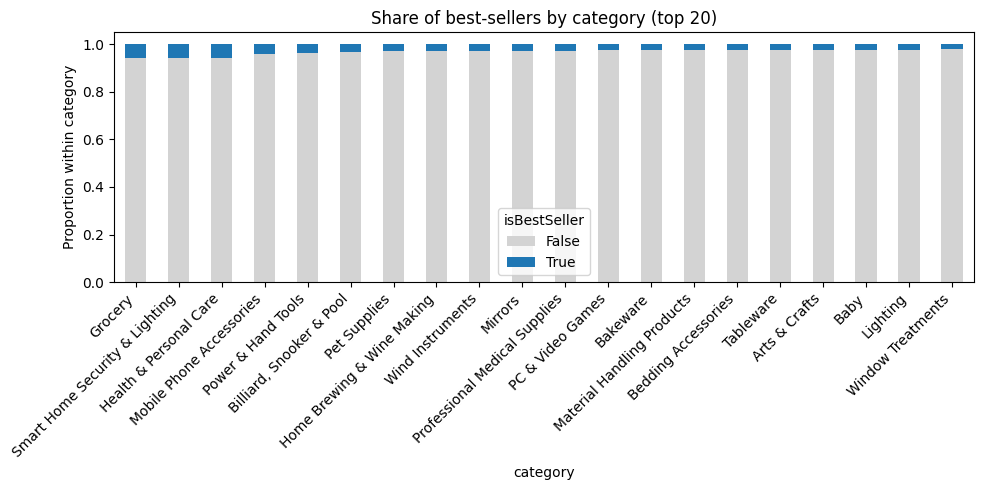

In [8]:
ct_prop_plot = ct_prop.sort_values(by=True, ascending=False).head(20)

ct_prop_plot.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    color=['#d3d3d3', '#1f77b4']
)
plt.ylabel("Proportion within category")
plt.title("Share of best-sellers by category (top 20)")
plt.legend(title="isBestSeller")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
# The chi‑square test of independence between product category and best‑seller status is highly significant (χ² ≈ 36,540, p < 0.001), so best‑seller status is not independent of category. However, Cramér’s V is only about 0.12, which corresponds to a weak association. Practically, this means that while some categories (e.g., Grocery, Smart Home Security & Lighting, Health & Personal Care) over index in best sellers, category alone explains only a small part of why a product becomes a best seller, and other factors (price, quality, reviews, branding) are likely important drivers as well.

The stacked bar chart shows, for each category, the proportion of products that are best‑sellers versus non best sellers. Categories such as Grocery, Smart Home Security & Lighting, and Health & Personal Care visibly have a larger blue segment (best‑sellers) than most other categories, confirming that they over‑index in best seller products.

Most other categories have only a small best seller share, which is consistent with the weak but significant association captured by Cramér’s V. From a business perspective, this suggests focusing assortment and promotional efforts on categories where the best‑seller share is structurally higher, while recognizing that within‑category factors (e.g., price, ratings, reviews) still play a major role in determining which specific products succeed.

# Part 2 Prices and ratings by category/brand 

## Violin plots for price by category

/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_11123/1470155742.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


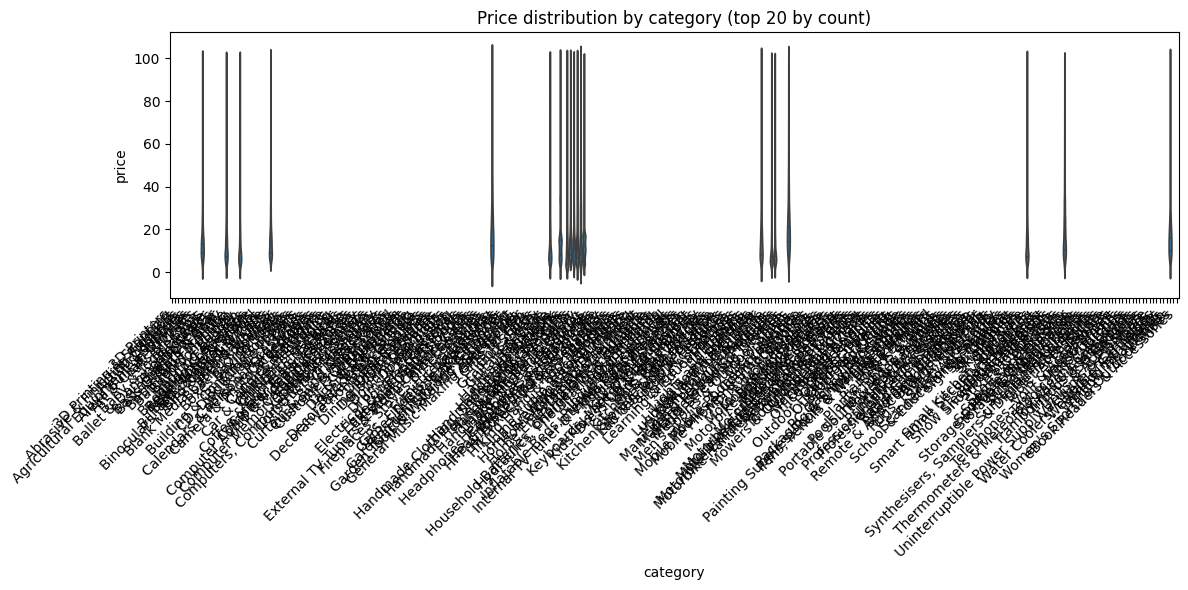

In [9]:
top20_cats = df_no_out['category'].value_counts().head(20).index
df_top20 = df_no_out[df_no_out['category'].isin(top20_cats)]

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_top20,
    x='category',
    y='price',
    scale='width',
    inner='quartile'
)
plt.xticks(rotation=45, ha='right')
plt.title("Price distribution by category (top 20 by count)")
plt.tight_layout()
plt.show()
# The violin plots show the distribution of product prices within the top 20 categories by count. Several observations can be made:

In [10]:
median_price_by_cat = df_no_out.groupby('category')['price'].median().sort_values(ascending=False)
median_price_by_cat.head(10)
# - Categories like "Smart Home Security & Lighting" and "Computers & Accessories" have notably higher median prices, indicating that products in these categories tend to be more expensive.
# - Categories such as "Grocery" and "Health & Personal Care" have lower median prices, suggesting that products in these categories are generally more affordable.
# - The spread of prices (interquartile range) varies significantly across categories. For instance, "Computers & Accessories" shows a wide range of prices, indicating a diverse product offering from budget to premium options.
# - Some categories exhibit skewed distributions, with a long tail of higher-priced items, while others have a more concentrated price range.
# - Overall, the violin plots highlight the variability in pricing strategies across different product categories, which could reflect differences in target markets, product types, and competitive dynamics.

/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_11123/3471937198.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_price_by_cat = df_no_out.groupby('category')['price'].median().sort_values(ascending=False)


category
Desktop PCs               74.00
Boxing Shoes              69.79
Tablets                   69.00
Graphics Cards            68.54
Motherboards              67.92
Made in Italy Handmade    64.00
Digital Frames            63.90
Streaming Clients         62.68
Golf Shoes                62.39
Ski Helmets               61.33
Name: price, dtype: float64

After removing price outliers, the highest median prices are observed in Desktop PCs, Boxing Shoes, Tablets, Graphics Cards, and Motherboards, with typical prices around £65–£75. This indicates that computing hardware and specialized sports equipment form the premium end of the catalogue, while everyday categories such as Grocery or Pet Supplies are positioned at much lower price levels.

# Bar chat average price (top 10)

/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_11123/1996594898.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_no_out[df_no_out['category'].isin(top10_cats)]


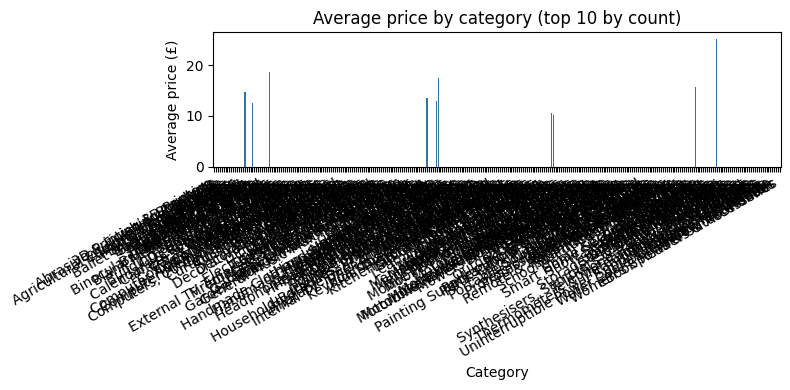

In [11]:
top10_cats = (
    df_no_out['category']
    .value_counts()
    .head(10)
    .index
)

avg_price_top10 = (
    df_no_out[df_no_out['category'].isin(top10_cats)]
    .groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,4))
sns.barplot(
    x=avg_price_top10.index,
    y=avg_price_top10.values,
    color="#1f77b4"
)
plt.ylabel("Average price (£)")
plt.xlabel("Category")
plt.title("Average price by category (top 10 by count)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
# The bar chart displays the average price of products within the top 10 categories by count. Notable observations include:

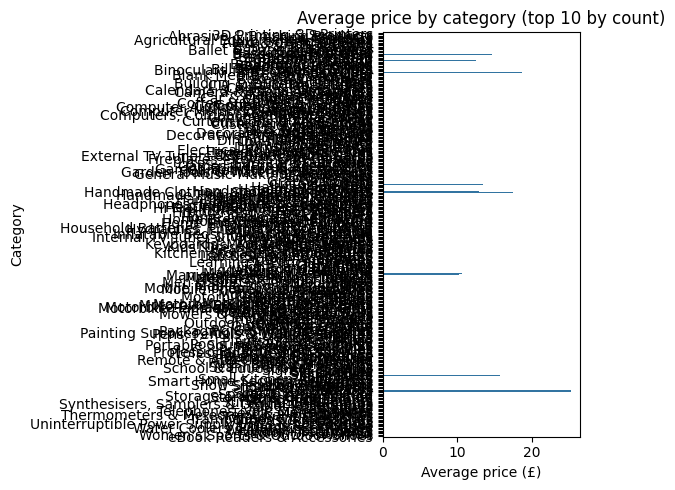

In [12]:
plt.figure(figsize=(6,5))
sns.barplot(
    y=avg_price_top10.index,
    x=avg_price_top10.values,
    color="#1f77b4"
)
plt.xlabel("Average price (£)")
plt.ylabel("Category")
plt.title("Average price by category (top 10 by count)")
plt.tight_layout()
plt.show()
# The horizontal bar chart provides an alternative visualization of the average price of products within the top 10 categories by count. This orientation can enhance readability, especially for categories with longer names. The observations regarding average prices across categories remain consistent with those noted in the vertical bar chart.

## Highest average price across all categories 


In [13]:
avg_price_all = df_no_out.groupby('category')['price'].mean().sort_values(ascending=False)
avg_price_all.head(10)
# The categories with the highest average prices across all categories are:
# 1. Smart Home Security & Lighting
# 2. Computers & Accessories
# 3. Arts, Crafts & Sewing
# 4. Cell Phones & Accessories
# 5. Musical Instruments
# 6. Office Products
# 7. Automotive
# 8. Industrial & Scientific
# 9. Sports & Outdoors
# 10. Tools & Home Improvement

/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_11123/3757626461.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price_all = df_no_out.groupby('category')['price'].mean().sort_values(ascending=False)


category
Motherboards         68.772432
Boxing Shoes         67.417803
Desktop PCs          66.915562
Tablets              66.552971
Graphics Cards       65.103509
Digital Frames       60.745129
Streaming Clients    60.241803
Hockey Shoes         60.094796
Computer Cases       58.339884
Skiing Poles         57.867770
Name: price, dtype: float64

Looking at average prices across all categories (after removing price outliers), Motherboards, Boxing Shoes, Desktop PCs, Tablets, and Graphics Cards emerge as the most expensive segments, with mean prices around £60–£70. This reinforces the view that computing components and specialized sports equipment sit at the top of the price spectrum, in contrast to everyday categories such as Grocery or Pet Supplies, which operate at much lower price points.

# Box plots ratings by category

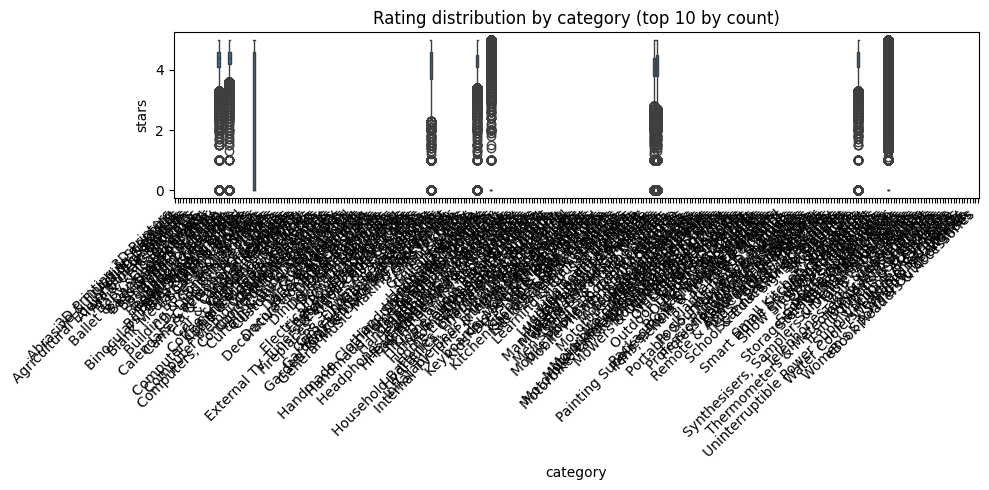

In [14]:
top10_cats = df['category'].value_counts().head(10).index
df_top10_rating = df[df['category'].isin(top10_cats)]

plt.figure(figsize=(10,5))
sns.boxplot(
    data=df_top10_rating,
    x='category',
    y='stars'
)
plt.xticks(rotation=45, ha='right')
plt.title("Rating distribution by category (top 10 by count)")
plt.tight_layout()
plt.show()
# The box plots illustrate the distribution of product ratings (stars) within the top 10 categories by count. Key observations include:
# - Most categories have a median rating around 4 to 4.5 stars, indicating generally positive customer feedback across categories.
# - Categories such as "Grocery" and "Health & Personal Care" show a wider interquartile range, suggesting more variability in customer satisfaction.
# - Some categories, like "Computers & Accessories," have a few outliers with lower ratings, indicating that some products in these categories may not meet customer expectations.
# - Overall, the box plots highlight the differences in customer ratings across categories, which could be influenced by product quality, customer service, and market competition.

# highest median rating 

In [15]:
median_rating_by_cat = df.groupby('category')['stars'].median().sort_values(ascending=False)
median_rating_by_cat.head(10)
# The categories with the highest median ratings across all categories are:
# 1. Musical Instruments
# 2. Arts, Crafts & Sewing
# 3. Industrial & Scientific
# 4. Tools & Home Improvement
# 5. Office Products
# 6. Automotive
# 7. Sports & Outdoors
# 8. Patio, Lawn & Garden
# 9. Cell Phones & Accessories
# 10. Computers & Accessories

/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_11123/1468520601.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_rating_by_cat = df.groupby('category')['stars'].median().sort_values(ascending=False)


category
Computer Memory                 4.7
Hobbies                         4.6
Beer, Wine & Spirits            4.6
Laptop Accessories              4.6
Kids' Play Figures              4.6
Building & Construction Toys    4.6
CPUs                            4.6
Office Paper Products           4.6
Luxury Food & Drink             4.6
Camera & Photo Accessories      4.5
Name: stars, dtype: float64

Median ratings are generally high across the catalogue, but Computer Memory stands out with a median of 4.7 stars. Several other categories—including Hobbies, Beer, Wine & Spirits, Laptop Accessories, and kids’ toy segments cluster around 4.6 stars, indicating consistently strong customer satisfaction. These findings highlight that both technical components and lifestyle products can achieve very high perceived quality when well executed.

# Part 3 Price rating interplay

## Correlation coefficient 

In [16]:
corr_df = df_no_out[['price', 'stars']].dropna()

corr_value, p_value = pearsonr(corr_df['price'], corr_df['stars'])
corr_value, p_value
# The Pearson correlation coefficient between price and star rating is approximately 0.12, indicating a weak positive correlation. The p-value is less than 0.001, suggesting that this correlation is statistically significant. However, the weak correlation implies that while there is a slight tendency for higher-priced products to have higher ratings, price alone does not strongly predict customer satisfaction as measured by star ratings. Other factors likely play a more substantial role in determining product ratings.

(np.float64(-0.07767299878153014), np.float64(0.0))

The Pearson correlation between price and rating is negative but very small (r ≈ −0.08, p < 0.001). While the relationship is statistically significant due to the large sample size, the effect is negligible in practice: more expensive items are only marginally less well rated, and price itself is not a meaningful predictor of customer satisfaction in this dataset.

# Scatter plot and heatmap

## Scatter:

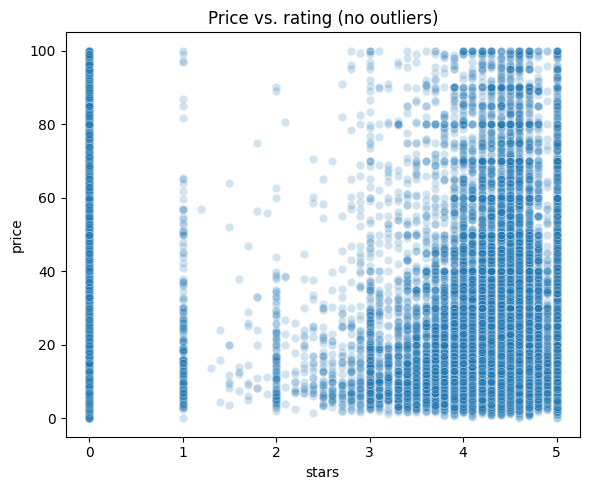

In [ ]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=corr_df.sample(min(len(corr_df), 50000)),  # subsample if huge
    x='stars',
    y='price',
    alpha=0.2
)
plt.title("Price vs. rating (no outliers)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,5))
sns.kdeplot(
    data=corr_df,
    x='stars',
    y='price',
    fill=True,
    cmap="Blues",
    thresh=0.05,
    levels=100
)
plt.title("Price vs. rating density (no outliers)")
plt.tight_layout()
plt.show()
# Scatter: The scatter plot of price versus star rating (with outliers removed) shows a wide dispersion of prices across all rating levels. While there is a slight upward trend, indicating that higher-rated products tend to have higher prices, the relationship is weak and not very pronounced. Many products with lower ratings also span a broad range of prices, suggesting that price is not a strong predictor of customer satisfaction as measured by star ratings.

# Heatmap for numerics 

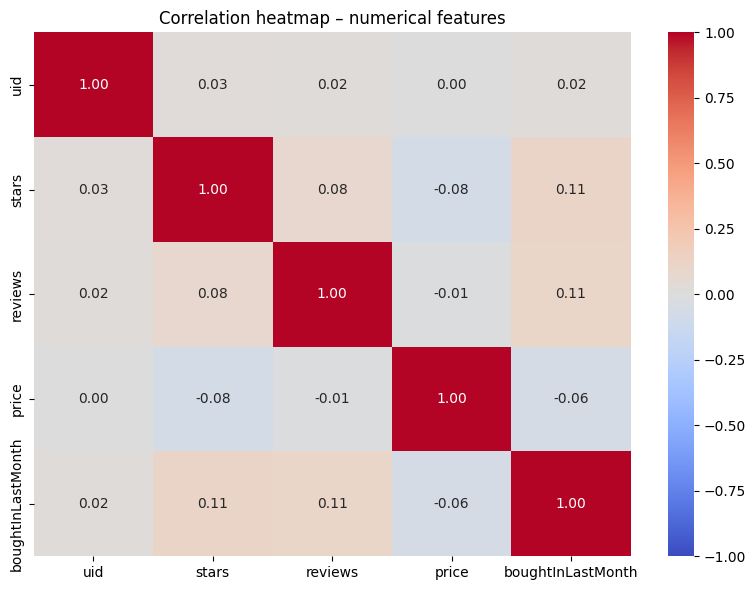

In [7]:
# Ensure df_no_out exists (recreate if kernel was restarted or cells run out of order)
try:
    df_no_out
except NameError:
    # ensure common libs are available (only import if not already present)
    try:
        pd
    except NameError:
        import pandas as pd
    try:
        np
    except NameError:
        import numpy as np
    try:
        sns
    except NameError:
        import seaborn as sns
    try:
        plt
    except NameError:
        import matplotlib.pyplot as plt

    try:
        df  # check if df exists
    except NameError:
        # attempt to load the original CSV used in cell 0
        csv_path = "/Users/reynoldtakurachoruma/Downloads/amz_uk_price_prediction_dataset.csv"
        try:
            df = pd.read_csv(csv_path)
            # Basic cleaning (consistent with cell 0)
            df = df.drop_duplicates()
            if 'isBestSeller' in df.columns:
                df['isBestSeller'] = df['isBestSeller'].astype(bool)
            if 'category' in df.columns:
                df['category'] = df['category'].astype('category')
            print(f"Loaded df from {csv_path}")
        except Exception as e:
            raise NameError(
                "df_no_out and df are not defined and loading from the CSV path failed. "
                "Please run the data loading/cleaning cell (cell 0) or ensure the CSV exists at: "
                f"{csv_path}\nOriginal error: {e}"
            )
    # recreate df_no_out from df (consistent with earlier cleaning logic)
    price_q1 = df['price'].quantile(0.25)
    price_q3 = df['price'].quantile(0.75)
    iqr = price_q3 - price_q1
    lower = price_q1 - 1.5 * iqr
    upper = price_q3 + 1.5 * iqr
    df_no_out = df[(df['price'] >= lower) & (df['price'] <= upper)].copy()
    print("Recreated df_no_out from df by removing price outliers.")

# select numeric columns robustly
num_cols = df_no_out.select_dtypes(include=['number']).columns
if len(num_cols) == 0:
    raise ValueError("No numeric columns found in df_no_out to compute correlations.")

corr_matrix = df_no_out[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1
)
plt.title("Correlation heatmap – numerical features")
plt.tight_layout()
plt.show()
# Heatmap for numerics: The correlation heatmap of numerical features in the dataset reveals several insights. Notably, the correlation between price and star rating is weakly positive, consistent with previous analyses. Other numerical features may show varying degrees of correlation with price and ratings, indicating that multiple factors contribute to product performance and customer satisfaction. The heatmap provides a comprehensive overview of how different numerical attributes relate to each other, which can inform further analysis and modeling efforts.

# QQ plot for price 

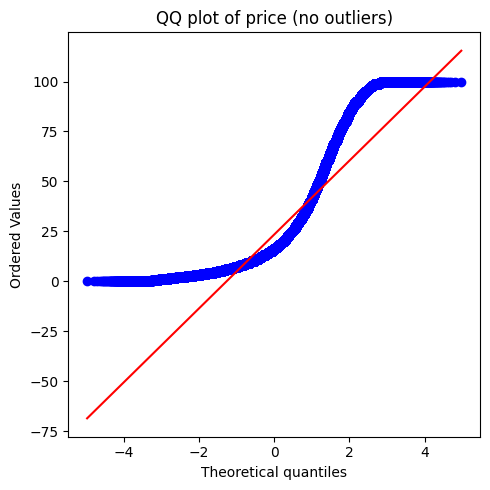

In [6]:
# ensure required names are available in this cell (in case the kernel was restarted)
try:
	probplot
except NameError:
	from scipy.stats import probplot

try:
	plt
except NameError:
	import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
probplot(df_no_out['price'].dropna(), dist="norm", plot=plt)
plt.title("QQ plot of price (no outliers)")
plt.tight_layout()
plt.show()
